In [2]:
import scanpy as sc
import numpy as np
import scipy as sp
from scipy import sparse
import pandas as pd
import xlrd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.3+115.g1aecabf anndata==0.6.22.post1 umap==0.3.9 numpy==1.16.4 scipy==1.3.0 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.0 python-igraph==0.7.1 louvain==0.6.1


In [4]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)
library(dplyr)
library(Seurat)

In [5]:
# Set up data loading

#Data files
sample_strings = ['E6.5_1', 'E7.0_1', 'E7.5_1', 'E7.5_2', 'E8.0_1ab', 'E8.5_1ab']
file_base = '../data/mammalian-embryogenesis/GSE122187_WT_'
data_file_end = '_matrix.mtx'
barcode_file_end = '_barcodes.tsv'
gene_file_end = '_genes.tsv'
cs_genes_file = '../data/mammalian-embryogenesis/GSE122187_CellStateKernels.xls'

In [6]:
# First data set load & annotation
#Parse Filenames
sample = sample_strings.pop(0)
data_file = file_base+sample+data_file_end
barcode_file = file_base+sample+barcode_file_end
gene_file = file_base+sample+gene_file_end

#Load data
adata = sc.read(data_file, cache=True)
adata = adata.transpose()
#adata.X = adata.X.toarray()

barcodes = pd.read_csv(barcode_file, header=None, sep='\t')
genes = pd.read_csv(gene_file, header=None, sep='\t')

#Annotate data
barcodes.rename(columns={0:'barcode'}, inplace=True)
barcodes.set_index('barcode', inplace=True)
adata.obs = barcodes
adata.obs['sample'] = [sample]*adata.n_obs
adata.obs['stage'] = [sample.split("_")[0]]*adata.n_obs
adata.obs['exp_number'] = [sample.split("_")[1]]*adata.n_obs

genes.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
genes.set_index('gene_symbol', inplace=True)
adata.var = genes
print(adata)

... reading from cache file cache/..-data-mammalian-embryogenesis-GSE122187_WT_E6.5_1_matrix.h5ad
AnnData object with n_obs × n_vars = 1843 × 27998 
    obs: 'sample', 'stage', 'exp_number'
    var: 'gene_id'


In [7]:
# Loop to load rest of data sets
for i in range(len(sample_strings)):
    #Parse Filenames
    sample = sample_strings[i]
    data_file = file_base+sample+data_file_end 
    barcode_file = file_base+sample+barcode_file_end
    gene_file = file_base+sample+gene_file_end
    
    #Load data
    adata_tmp = sc.read(data_file, cache=True)
    adata_tmp = adata_tmp.transpose()
    #adata_tmp.X = adata_tmp.X.toarray()

    barcodes_tmp = pd.read_csv(barcode_file, header=None, sep='\t')
    genes_tmp = pd.read_csv(gene_file, header=None, sep='\t')
    
    #Annotate data
    barcodes_tmp.rename(columns={0:'barcode'}, inplace=True)
    barcodes_tmp.set_index('barcode', inplace=True)
    adata_tmp.obs = barcodes_tmp
    adata_tmp.obs['sample'] = [sample]*adata_tmp.n_obs
    adata_tmp.obs['stage'] = [sample.split("_")[0]]*adata_tmp.n_obs
    adata_tmp.obs['exp_number'] = [sample.split("_")[1]]*adata_tmp.n_obs
    
    genes_tmp.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
    genes_tmp.set_index('gene_symbol', inplace=True)
    adata_tmp.var = genes_tmp
    adata_tmp.var_names_make_unique()

    # Concatenate to main adata object
    adata = adata.concatenate(adata_tmp, batch_key='sample')
    #adata.obs.drop(columns=['sample'], inplace=True)
    adata.obs_names = [c.split("-")[0] for c in adata.obs_names]
    adata.obs_names_make_unique(join='_')

    
print(adata)


... reading from cache file cache/..-data-mammalian-embryogenesis-GSE122187_WT_E7.0_1_matrix.h5ad


Making variable names unique for controlled concatenation.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


... reading from cache file cache/..-data-mammalian-embryogenesis-GSE122187_WT_E7.5_1_matrix.h5ad


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


... reading from cache file cache/..-data-mammalian-embryogenesis-GSE122187_WT_E7.5_2_matrix.h5ad


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


... reading from cache file cache/..-data-mammalian-embryogenesis-GSE122187_WT_E8.0_1ab_matrix.h5ad


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Or pass `index_unique!=None` to `.concatenate`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


... reading from cache file cache/..-data-mammalian-embryogenesis-GSE122187_WT_E8.5_1ab_matrix.h5ad


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Or pass `index_unique!=None` to `.concatenate`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 92649 × 27998 
    obs: 'exp_number', 'sample', 'stage'
    var: 'gene_id'


In [21]:

#later = 
print(adata.obs['stage'].tolist())
#print(adata.obs_names['stage'])

['E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5', 'E6.5',

In [14]:
adata_mini = adata.chunk_X(select=43000, replace=True)

In [16]:
adata_mini.shape

(43000, 27998)

In [9]:
cs_genes = pd.read_excel(cs_genes_file, index_col=0, header=1)
#Re-order cell-state genes dataframe so it matches the order in adata
cs_genes.reindex(adata.var_names).dropna()

,0,1,10,11,12,13,14,15,16,17,...,38,39,4,40,41,5,6,7,8,9
Sox17,0.009551,0.010160,0.127679,0.033837,0.044271,0.283223,0.784152,0.006573,0.013448,0.003336,...,0.038042,0.003911,0.498522,0.050063,0.004212,0.062268,0.008096,0.671847,0.017514,0.005387
Sulf1,0.011710,0.131620,0.133571,0.069627,0.063676,0.031192,0.031677,0.190402,0.090009,0.144860,...,0.479580,0.077916,0.080768,0.041175,0.225162,0.083789,0.127159,0.178471,0.122531,0.009462
Tfap2b,0.000152,0.036348,0.099334,0.026995,0.000912,0.001393,0.001087,0.006897,0.180666,0.000000,...,0.000000,0.030411,0.001582,0.004394,0.003104,0.001397,0.002022,0.001496,0.000396,0.003893
Col9a1,0.001239,0.011547,0.013379,0.008895,0.106973,0.021658,0.006832,0.149087,0.047665,0.000000,...,0.067389,0.006403,0.001238,0.002715,0.273960,0.113400,0.113418,0.005575,0.002284,0.003784
Col3a1,0.000768,0.002311,0.007002,0.002244,0.013164,0.015670,0.006897,0.642970,0.012218,0.000000,...,0.000000,0.012889,0.002588,0.018233,0.895527,0.053771,0.235714,0.004634,0.000283,0.006940
Col5a2,0.002139,0.011033,0.016085,0.005032,0.014034,0.067437,0.004212,0.405109,0.038141,0.017939,...,0.019568,0.027727,0.004841,0.002541,0.679344,0.067698,0.146167,0.017321,0.011641,0.005189
Sdpr,0.000327,0.001020,0.005947,0.001127,0.004629,0.003586,0.003992,0.346030,0.061271,0.000000,...,0.002279,0.003003,0.001142,0.007704,0.642751,0.025362,0.031948,0.004328,0.000456,0.001144
Fn1,0.125451,0.243698,0.498570,0.124939,0.426719,0.988441,0.162227,0.931037,0.445198,0.224184,...,0.414430,0.250851,0.622304,0.770372,0.963646,0.862040,0.719373,0.858619,0.167972,0.373994
Igfbp2,0.255559,0.886756,0.870664,0.837011,0.350568,0.344831,0.131140,1.191979,1.114685,0.992901,...,0.661248,0.788996,0.826123,0.107366,1.366042,0.463221,0.507570,1.042718,1.008307,0.089224
Igfbp5,0.008973,0.155957,0.820500,0.126268,0.027038,0.066060,0.015334,0.091566,0.504560,0.019119,...,0.581329,0.174411,0.246543,0.331489,0.211346,0.154234,0.329377,0.740102,0.031428,0.026882


In [10]:
print(len(cs_genes.index.values))
used_genes = cs_genes.index.values

712


In [11]:
# Annotate the data sets
#print(adata.obs)
print(adata.obs['stage'].value_counts())
print('')
print(adata.obs['exp_number'].value_counts())
print('')
#print(adata.obs['sample'].value_counts())

E7.5    28233
E8.5    24780
E8.0    24342
E7.0    13451
E6.5     1843
Name: stage, dtype: int64

1ab    49122
1      29917
2      13610
Name: exp_number, dtype: int64



In [10]:
# Checking the total size of the data set
adata.shape

(92649, 27998)

In [11]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = np.ravel(adata.X.sum(1))
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)
print(np.ravel(adata.X.sum(1)))
mt_gene_mask = [gene.startswith('mt-') for gene in adata.var_names]
print((adata.X.toarray()[:, mt_gene_mask]))
adata.obs['mt_frac'] = (adata.X.toarray()[:, mt_gene_mask]).sum(1)/adata.obs['n_counts']
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

[21203. 10915. 24615. ... 24310. 14522. 13764.]
[[106.  23.  94. ...  13.   0.  78.]
 [ 78.  31. 150. ...   3.   0.  74.]
 [ 83.  28.  64. ...  13.   0.  90.]
 ...
 [106.  22.  49. ...   2.   0.  54.]
 [  2.   0.   3. ...   0.   0.   1.]
 [ 66.  13.  46. ...   5.   0.  53.]]
Total number of genes: 27998


Dataset was already filtered through Quality Control variables

## 2.2 Normalisation

Up to this point the data is only available as a count matrix. Counts are representative of molecules that were captured in the scRNA-seq experiment. As not all mRNA molecules in a cell are captured, there is a variability in the total number of counts detected between cells that results from both the number of molecules that were in the cells, and the sampling. As we cannot assume that all cells contain an equal number of molecules (cell sizes can differ substantially), we have to estimate the number of molecules that were initially in the cells. In fact, we don't estimate the exact number of molecules, but instead estimate cell-specific factors that should be proportional to the true number of molecules. These are called size factors. Normalized expression values are calculated by dividing the measured counts by the size factor for the cell.

Based on comparisons of normalization methods for differential testing (personal communication from Beathe Vieth), and batch correction [Buettner et al., 2019], the normalization method implemented in the scran package performs best. This method requires a coarse clustering input to improve size factor esimation performance. Thus, we use a simple preprocessing approach and cluster the data at a low resolution to get an input for the size factor estimation. The basic preprocessing includes assuming all size factors are equal (library size normalization to counts per million - CPM) and log-transforming the count data.

In [12]:
adata.obs['log_counts'].values

array([ 9.961898,  9.297894, 10.111112, ..., 10.098643,  9.58342 ,
        9.529812], dtype=float32)

In [ ]:
#Log-normalise data, Regress out UMI counts
adata = adata.copy()
sc.pp.normalize_total(adata, target_sum = 10000)
sc.pp.log1p(adata)

In [14]:
yay = np.in1d(adata.var_names, used_genes)
adata = adata[:, yay]
print(yay)
print(len(yay))
print(adata)


[False False False ... False False False]
27998
View of AnnData object with n_obs × n_vars = 92649 × 712 
    obs: 'exp_number', 'sample', 'stage', 'n_counts', 'log_counts', 'n_genes', 'mt_frac'
    var: 'gene_id'


We have 92649 cells and 712 genes. So now I have reduced my anndata object so only the genes we care about are included.



In [15]:
sc.pp.regress_out(adata, keys = ['n_counts'])
sc.pp.pca(adata, n_comps=15)
sc.pp.neighbors(adata)
sc.tl.louvain(adata, key_added='groups', resolution=0.5)

regressing out ['n_counts']


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


    finished (0:00:28)
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 15
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 15


/home/hunge/anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /home/hunge/anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/rp_tree.py (457)

File "../../anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recursive(type(CPUDi

    finished (0:00:23)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:25)


In [16]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [17]:
# converted to dense matrix so convert back
adata.X = sparse.csr_matrix(adata.X)

Before normalizing the data, we ensure that a copy of the raw count data is kept in a separate AnnData object. This allows us to use methods downstream that require this data as input.

In [18]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

## 2.5 Visualisation

Visualizing scRNA-seq data is the process of projecting a high-dimensional matrix of cells and genes into a few coordinates such that every cell is meaningfully represented in a two-dimensional graph. However, the visualization of scRNA-seq data is an active area of research and each method defines 'meaningful' in its own way. Thus, it is a good idea to look at several visualizations and decide which visualization best represents the aspect of the data that is being investigated.

Overall t-SNE visualizations have been very popular in the community, however the recent UMAP algorithm has been shown to better represent the topology of the data.

Note that we do not scale the genes to have zero mean and unit variance. A lack of rescaling is equivalent to giving genes with a higher mean expression a higher weight in dimensionality reduction (despite correcting for mean offsets in PCA, due to the mean-variance relationship). We argue that this weighting based on mean expression being a biologically relevant signal. However, rescaling HVG expression is also common, and the number of publications that use this approach suggests that scaling is at least not detrimental to downstream scRNA-seq analysis.

(Timing: 11 min 18s and 14 min 45s)


In [19]:
# Calculate the visualizations
sc.pp.pca(adata, n_comps=50, use_highly_variable=False, svd_solver='arpack')
sc.pp.neighbors(adata)

sc.tl.tsne(adata, n_jobs=12) #Note n_jobs works for MulticoreTSNE, but not regular implementation)
sc.tl.umap(adata)
sc.tl.diffmap(adata)
sc.tl.draw_graph(adata)

computing PCA with n_comps = 50
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 50


/home/hunge/anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


    finished (0:00:25)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:08:21)
computing UMAP
    finished (0:02:12)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9977315  0.9974365  0.99724007 0.9961541  0.9950691
     0.99401796 0.99311167 0.9914819  0.99136955 0.9908278  0.9904553
     0.98884237 0.9884133  0.988104  ]
    finished (0:00:11)
drawing single-cell graph using layout 'fa'
    finished (0:14:45)


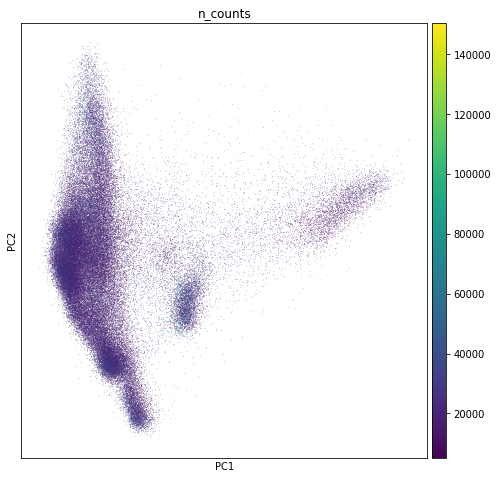

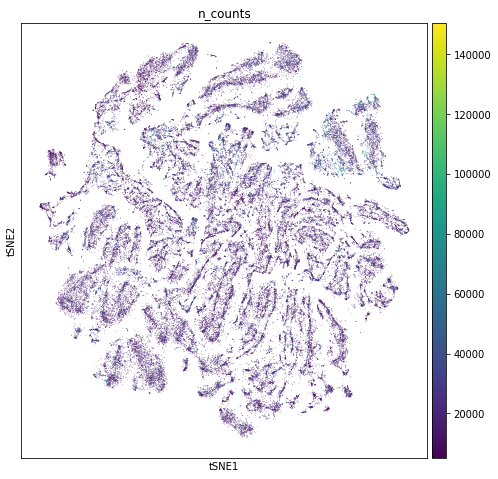

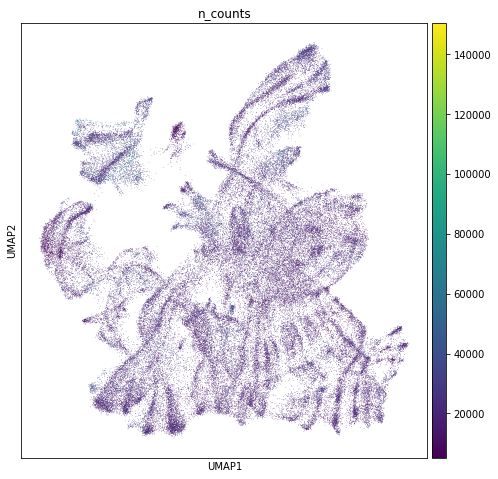

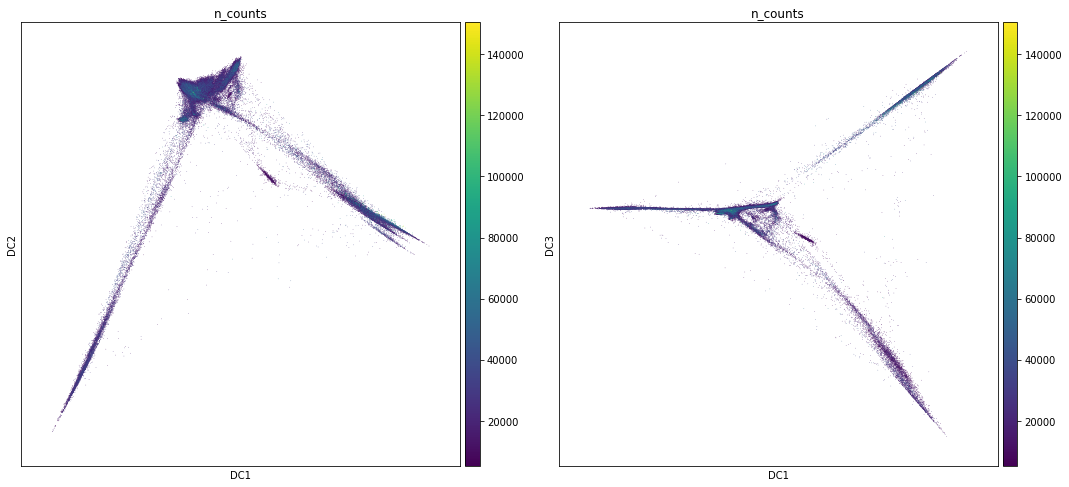

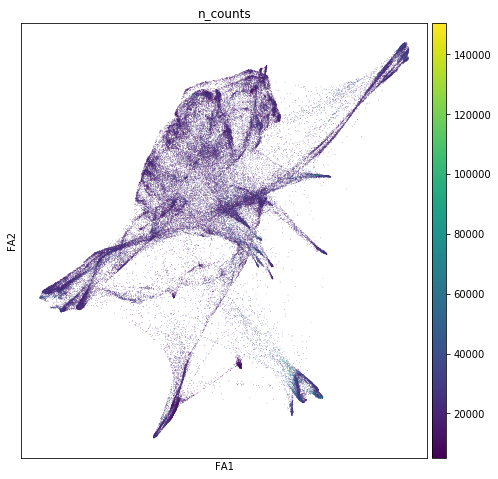

In [22]:
sc.pl.pca_scatter(adata, color='n_counts')
sc.pl.tsne(adata, color='n_counts')
sc.pl.umap(adata, color='n_counts')
sc.pl.diffmap(adata, color='n_counts', components=['1,2','1,3'])
sc.pl.draw_graph(adata, color='n_counts')

## 3 Downstream Analysis

## 3.1 Clustering

What we want to do next is to cluster the cells by matching the profile of each cell to profiles for each cluster

In [23]:
#cs_genes.columns
cs_genes.columns.values
cols = cs_genes.columns.tolist()
cols.sort() 
#Now indices of columns list is same as cluster label
#i.e. cs_genes.columns[i] corresponds to cluster i
cs_genes = cs_genes[cols]
#Checking length
len(cs_genes.columns)

42

In [42]:
#Testing distance between cluster centres
wow = cs_genes.values[:,0].reshape(712,1) - cs_genes.values[:,3].reshape(712,1)
magni_test = np.linalg.norm(wow)
print(magni_test)

5.880130394836835


In [41]:
wowe = adata.X.T[:,33000] - cs_genes.values[:,3].reshape(712,1)
magnit_test = np.linalg.norm(wowe)
print(magnit_test)

10.676003240586807


In [43]:
#Create an empty list which will store the cluster label of each cell.
c_states =[]
vals = cs_genes.values
x_t = adata.X.T
for i in range(0, adata.n_obs):
    #Creates a difference vector diff_tmp vector of length 
    #cs_genes.columns
    diff_tmp = [] 
    for j in range(0, len(cs_genes.columns)):
        #Take a cluster vector and find magnitude of difference
        
        cluster_temp = vals[:,j].reshape(712,1)
        diff_vector = np.linalg.norm(x_t[:,i]-cluster_temp)
        mag = np.linalg.norm(diff_vector)
        diff_tmp.append(mag)
        
    #Find index of min value in the difference vector
    ind = np.argmin(diff_tmp)
    #Find cluster label this index corresponds to, append to c_states
    c_states.append(ind)

In [38]:
#np.where(c_states == 39)

In [44]:
#c_states = np.asarray(c_states)
adata.obs.loc[:, "cell_state_marker"] = c_states
#adata.obs['Cell_state_marker']= anno['Cell_state_marker']

In [45]:
type(adata.obs['cell_state_marker'].values)
#print(adata.obs['cell_state_marker'])

numpy.ndarray

In [46]:
#adata.obs['cell_state_marker']
adata.obs['cell_state_marker'].value_counts()

22    66719
35    10851
36     8344
9      2068
17     1676
13     1316
19      430
20      288
33      209
3       163
27      153
1       121
37       98
34       85
0        40
5        29
12       26
6        12
2        11
10        6
8         2
39        2
Name: cell_state_marker, dtype: int64

In [28]:
#print(adata.X.T[:,0])

In [47]:
type(adata.obs['cell_state_marker'])

pandas.core.series.Series

In [48]:
adata.obs['cell_state_marker'] = adata.obs['cell_state_marker'].astype('category')

In [49]:
#adata.obs['cell_state_marker'].to_string

In [50]:
adata.obs['cell_state_marker'].dtype

CategoricalDtype(categories=[0, 1, 2, 3, 5, 6, 8, 9, 10, 12, 13, 17, 19, 20, 22, 27, 33,
                  34, 35, 36, 37, 39],
                 ordered=False)

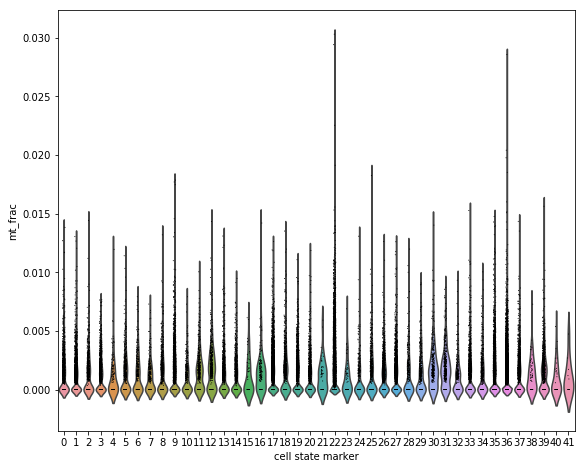

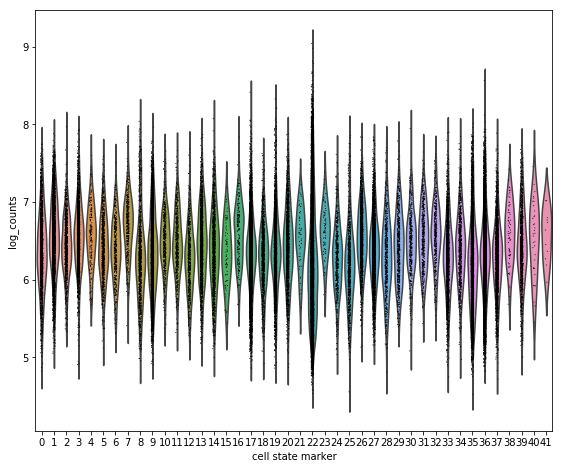

In [37]:
sc.pl.violin(adata, 'mt_frac', groupby='cell_state_marker')
sc.pl.violin(adata, 'log_counts', groupby='cell_state_marker')

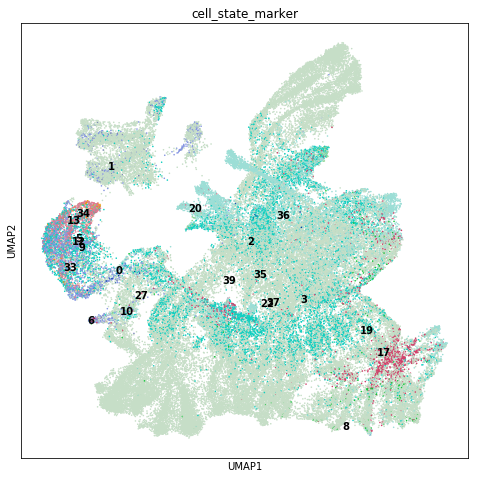

In [51]:
sc.pl.umap(adata, color='cell_state_marker', size=10, legend_loc='on data')

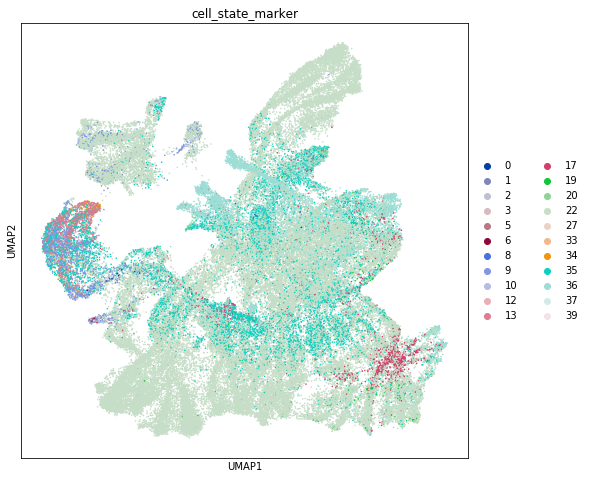

In [52]:
sc.pl.umap(adata, color='cell_state_marker', size=10)

## 3.5 Trajectory Inference and pseudotime analysis

computing PCA with n_comps = 50
    finished (0:00:11)


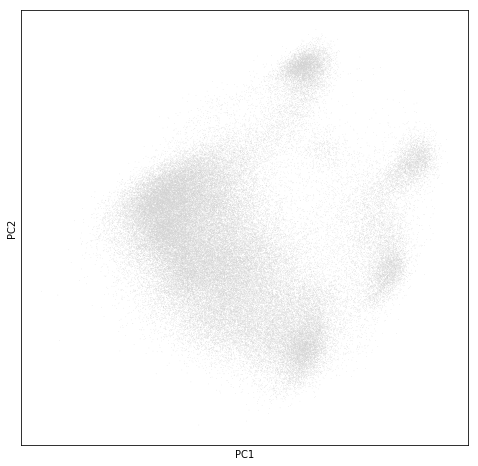

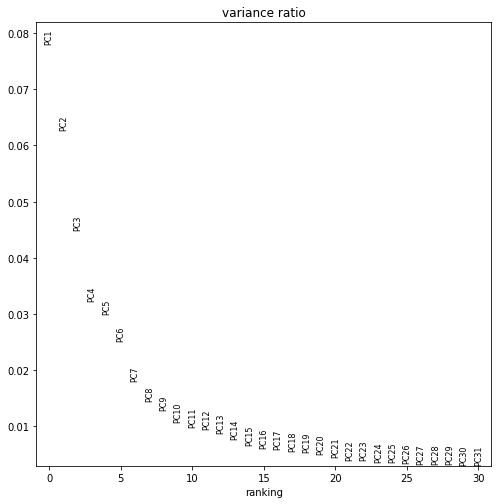

In [33]:
#Recalculating PCA
sc.pp.pca(adata, svd_solver='arpack')
sc.pl.pca(adata)
sc.pl.pca_variance_ratio(adata)

In [34]:
adata.obsm['X_pca'] = adata.obsm['X_pca'][:,0:6]

# Slingshot method

In [50]:
type(adata.obs['cell_state_marker'].values)

pandas.core.arrays.categorical.Categorical

In [51]:
adata.obs['cell_state_marker'] = adata.obs['cell_state_marker'].to_string()

In [ ]:
%%R -i adata

#Plot 1
colour_map = brewer.pal(20,'Set1')
par(xpd=TRUE)
par(mar=c(4.5,5.5,2,7))
plot(reducedDims(adata)$PCA[,1], reducedDims(adata)$PCA[,2], col=colour_map[colData(adata)$cell_state_marker], bty='L', xlab='PC1', ylab='PC2')
legend(x=12, y=12, legend=unique(colData(adata)$cell_state_marker), fill=colour_map[as.integer(unique(colData(adata)$cell_state_marker))])

print("1:")
adata_start <- slingshot(adata, clusterLabels = 'cell_state_marker', reducedDim = 'PCA', start.clus='17')
print(SlingshotDataSet(adata_start))

print("")
#print("2:")
#adata_startend <- slingshot(adata, clusterLabels = 'Cell_state_marker', reducedDim = 'PCA', start.clus='17', end.clus=c('33', '24'))
#print(SlingshotDataSet(adata_startend))

#print("")
#print("3:")
#adata_simple_startend <- slingshot(adata, clusterLabels = 'Cell_state_marker', reducedDim = 'PCA', start.clus='17', end.clus= '33')
#print(SlingshotDataSet(adata_simple_startend))

/home/hunge/anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/anndata2ri/py2r.py:45: UserWarning: Duplicated obs_names: Index(['AAAGATGAGAACAACT_1', 'AAAGATGAGAACAACT_1', 'AACACGTCATCGGGTC_1',
       'AACACGTCATCGGGTC_1', 'AACCATGTCAAGGTAA_1', 'AACCATGTCAAGGTAA_1',
       'AACTTTCAGAAGGTTT_1', 'AACTTTCAGAAGGTTT_1', 'AATCCAGTCGTAGGTT_1',
       'AATCCAGTCGTAGGTT_1',
       ...
       'TGGCTGGGTATGAATG_1', 'TGGCTGGGTATGAATG_1', 'TTAGTTCAGGCAGGTT_1',
       'TTAGTTCAGGCAGGTT_1', 'TTATGCTTCCGCGTTT_1', 'TTATGCTTCCGCGTTT_1',
       'TTCCCAGAGAGACTAT_1', 'TTCCCAGAGAGACTAT_1', 'TTTATGCCAGCGTCCA_1',
       'TTTATGCCAGCGTCCA_1'],
      dtype='object', length=204)
  warn(f"Duplicated {name}: {idx[idx.duplicated(False)].sort_values()}")


In [47]:
%%R

#Plot of lineage 1
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_startend)$PCA[,c(1,2)], col = colors[cut(adata_startend$slingPseudotime_1,breaks=100)], pch=16, asp = 1, xlab='PC1', ylab='PC2')
lines(slingCurves(adata_startend)$curve1, lwd=2)


Error in reducedDims(adata_startend) : object 'adata_startend' not found
Calls: <Anonymous> ... <Anonymous> -> <Anonymous> -> withVisible -> plot -> reducedDims


In [ ]:
%%R

#Plot of lineage 1
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_startend)$PCA[,c(1,2)], col = colors[cut(adata_startend$slingPseudotime_1,breaks=100)], pch=16, asp = 1, xlab='PC1', ylab='PC2')
lines(slingCurves(adata_startend)$curve1, lwd=2)

#Plot of lineage 2
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_startend)$PCA[,c(1,2)], col = colors[cut(adata_startend$slingPseudotime_2,breaks=100)], pch=16, asp = 1, xlab='PC1', ylab='PC2')
lines(slingCurves(adata_startend)$curve2, lwd=2)

#Plot of lineages with clusters visualized
par(xpd=TRUE)
plot(reducedDims(adata_startend)$PCA[,c(1,2)], col = brewer.pal(11,'Set1')[adata$Cell_state_marker], pch=16, asp = 1, bty='L', xlab='PC1', ylab='PC2')
lines(SlingshotDataSet(adata_startend), lwd=2, type='lineages')
legend(x=10, y=20, legend=unique(colData(adata)$Cell_state_marker), fill=brewer.pal(11,'Set1')[as.integer(unique(colData(adata)$Cell_state_marker))])

#Plot of simpler clustering
plot(reducedDims(adata_simple_startend)$PCA[,c(1,2)], col = colors[cut(adata_simple_startend$slingPseudotime_1,breaks=100)], pch=16, asp = 1, xlab='PC1', ylab='PC2')
lines(SlingshotDataSet(adata_simple_startend), lwd=2)

### 3.5.2 Non-batch-corrected slingshot

### 3.53 Monocle2

In [72]:
adata.obs['cell_state_marker'] = adata.obs['cell_state_marker'].astype(str)

In [73]:
#Preprocessing for monocle
data_mat_mon = adata.layers['counts'].T
var_mon=adata.var.copy()
obs_mon=adata.obs.copy()

In [74]:
%%R -i data_mat_mon -i obs_mon -i var_mon

#Set up the CellDataSet data structure
pd <- AnnotatedDataFrame(data = obs_mon)
fd <- AnnotatedDataFrame(data = var_mon)
colnames(data_mat_mon) <- rownames(pd)
rownames(data_mat_mon) <- rownames(fd)
ie_regions_cds <- newCellDataSet(cellData=data_mat_mon, phenoData=pd, featureData=fd, expressionFamily=negbinomial.size())

#Normalize the count data
ie_regions_cds <- estimateSizeFactors(ie_regions_cds)

#Calculate dispersions to filter for highly variable genes
ie_regions_cds <- estimateDispersions(ie_regions_cds)


#Filter 
cell_types = as.character(pData(ie_regions_cds)$cell_state_marker)
cell_mask = rep(FALSE, length(cell_types))
cells_to_keep = c("cell_state_marker")
for (item in cells_to_keep) {cell_mask = cell_mask | startsWith(cell_types, item)}
print("Number of cells after filtering:")
print(sum(cell_mask))
print("")

#Filter highly variable genes from our analysis
hvg_mask = fData(ie_regions_cds)$highly_variable
ie_regions_cds <- ie_regions_cds[hvg_mask, cell_mask]

#Do dimensionality reduction
ie_regions_cds <- reduceDimension(ie_regions_cds, norm_method = 'vstExprs', reduction_method='DDRTree', verbose = F, max_components = 7)

#Run for the first time to get the ordering
ie_regions_cds <- orderCells(ie_regions_cds)

#Find the correct root state the corresponds to the 'Stem' cluster
tab1 <- table(pData(ie_regions_cds)$State, pData(ie_regions_cds)$cell_state_marker)
id = which(colnames(tab1) == 'Stem')
root_name = names(which.max(tab1[,id]))

#Run a second time to get the correct root state that overlaps with Stem cells
ie_regions_cds <- orderCells(ie_regions_cds, root_state=root_name)

[1] "Number of cells after filtering:"
[1] 0
[1] ""

Error in orig[[nm]][i, j, ..., drop = drop] : 
  invalid or not-yet-implemented 'Matrix' subsetting
Calls: <Anonymous> ... <Anonymous> -> <Anonymous> -> withVisible -> [ -> [ -> [ -> [


In [75]:
%%R -w 1000 -h 800

#Get a nice colour map
custom_colour_map = brewer.pal(length(unique(pData(ie_regions_cds)$louvain_final)),'Paired')

#Find the correct root state that coresponds to the 'Stem' cluster
tab1 <- table(pData(ie_regions_cds)$State, pData(ie_regions_cds)$louvain_final)
id = which(colnames(tab1) == 'Stem')
root_name = names(which.max(tab1[,id]))

# Visualize with our cluster labels
options(repr.plot.width=5, repr.plot.height=4)
plot_complex_cell_trajectory(ie_regions_cds, color_by = 'louvain_final', show_branch_points = T, 
                             cell_size = 2, cell_link_size = 1, root_states = c(root_name)) +
scale_size(range = c(0.2, 0.2)) +
theme(legend.position="left", legend.title=element_blank(), legend.text=element_text(size=rel(1.5))) +
guides(colour = guide_legend(override.aes = list(size=6))) + 
scale_color_manual(values = custom_colour_map)


Error in if (cds@dim_reduce_type == "ICA") { : argument is of length zero
Calls: <Anonymous> ... <Anonymous> -> withVisible -> plot_complex_cell_trajectory


In [76]:
%%R -w 600 -h 800

#Visualize pseudotime found
options(repr.plot.width=5, repr.plot.height=4)
plot_cell_trajectory(ie_regions_cds, color_by="Pseudotime")


Error in if (cds@dim_reduce_type == "ICA") { : argument is of length zero
Calls: <Anonymous> ... <Anonymous> -> <Anonymous> -> withVisible -> plot_cell_trajectory


### 3.5.4 Diffusion Pseudotime (DPT)

In [47]:
sc.pp.neighbors(adata)
sc.tl.diffmap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50


/home/hunge/anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


    finished (0:00:23)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9973329  0.9968284  0.9959088  0.9946698  0.9945319
     0.99222314 0.9894969  0.98856544 0.9881972  0.9872225  0.9862849
     0.9859361  0.9854635  0.984302  ]
    finished (0:00:09)


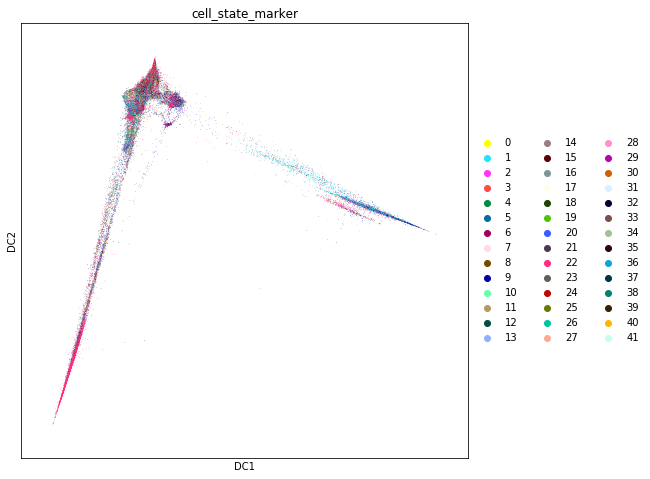

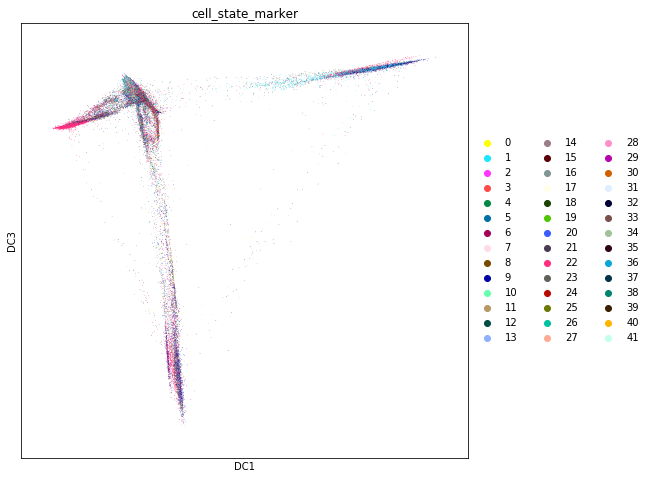

In [48]:
sc.pl.diffmap(adata, components='1,2', color='cell_state_marker')
sc.pl.diffmap(adata, components='1,3', color='cell_state_marker')

In [49]:
#Find the stem cell with the highest DC3 value to act as root for the diffusion pseudotime and compute DPT
stem_mask = np.isin(adata.obs['cell_state_marker'], '17')
max_stem_id = np.argmin(adata.obsm['X_diffmap'][stem_mask,2])
root_id = np.arange(len(stem_mask))[stem_mask][max_stem_id]
adata.uns['iroot'] = root_id

#Compute dpt
sc.tl.dpt(adata)

/home/hunge/anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


ValueError: attempt to get argmin of an empty sequence

In [ ]:
#Visualize pseudotime over differentiation
sc.pl.diffmap(adata, components='1,3', color='dpt_pseudotime')

## 3.6 Gene expression dynamics

In [ ]:
%%R

#Set the pseudotime variable
t <- adata_ent_simple_startend$slingPseudotime_1

#Extract the gene expression matrix
Y <- assay(adata_ent_simple_startend)

# fit a GAM with a loess term for pseudotime
#Note: This takes a while
gam.pval <- apply(Y,1,function(z){
  d <- data.frame(z=z, t=t)
  tmp <- gam(z ~ lo(t), data=d)
  p <- summary(tmp)[4][[1]][1,5]
  p
})

In [ ]:
%%R -w 600 -h 1200

#Select the top 100 most significant genes that change over pseudotime
topgenes <- names(sort(gam.pval, decreasing = FALSE))[1:100]
heatdata <- assay(adata_ent_simple_startend)[rownames(assay(adata_ent_simple_startend)) %in% topgenes, 
                        order(t, na.last = NA)]

#Scale the data per gene for visualization
heatdata <- t(scale(t(heatdata)))

#Trimm z-score scale
heatdata[heatdata > 3] = 3
heatdata[heatdata < -3] = -3

#Get cluster assignment
heatclus <- adata_ent_simple_startend$louvain_r0.5[order(t, na.last = NA)]

#Set up a clusterExperiment data structure for heatmap visualization
ce <- ClusterExperiment(heatdata, heatclus, transformation = function(x){x})

#Plot the heatmap
plotHeatmap(ce, clusterSamplesData = "orderSamplesValue", visualizeData = 'transformed', fontsize=15)

## 3.8 Partition-based graph abstraction

running PAGA
    finished (0:00:04)
--> added 'pos', the PAGA positions (adata.uns['paga'])


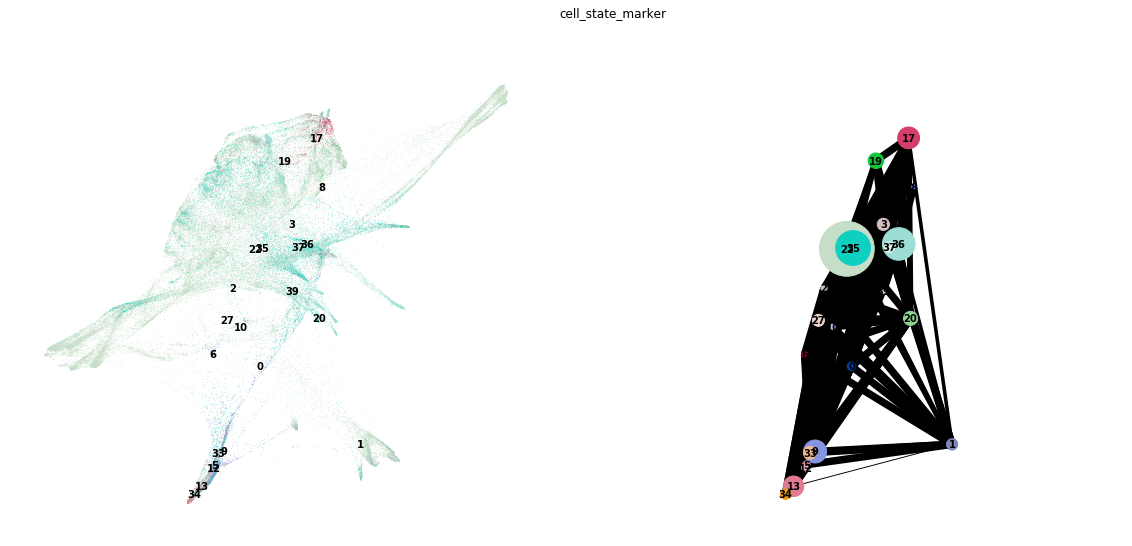

--> added 'pos', the PAGA positions (adata.uns['paga'])


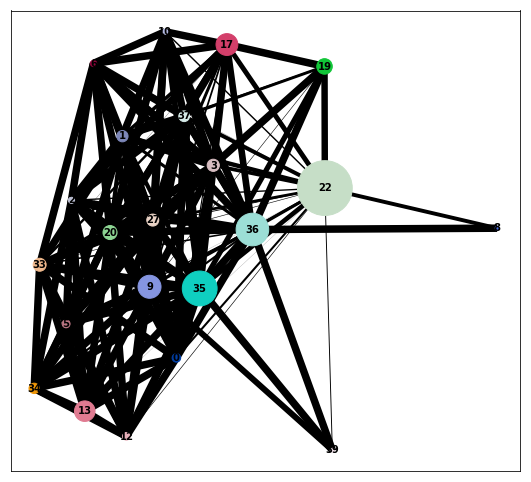

In [53]:
sc.tl.paga(adata, groups='cell_state_marker')
sc.pl.paga_compare(adata)
sc.pl.paga(adata)

--> added 'pos', the PAGA positions (adata.uns['paga'])


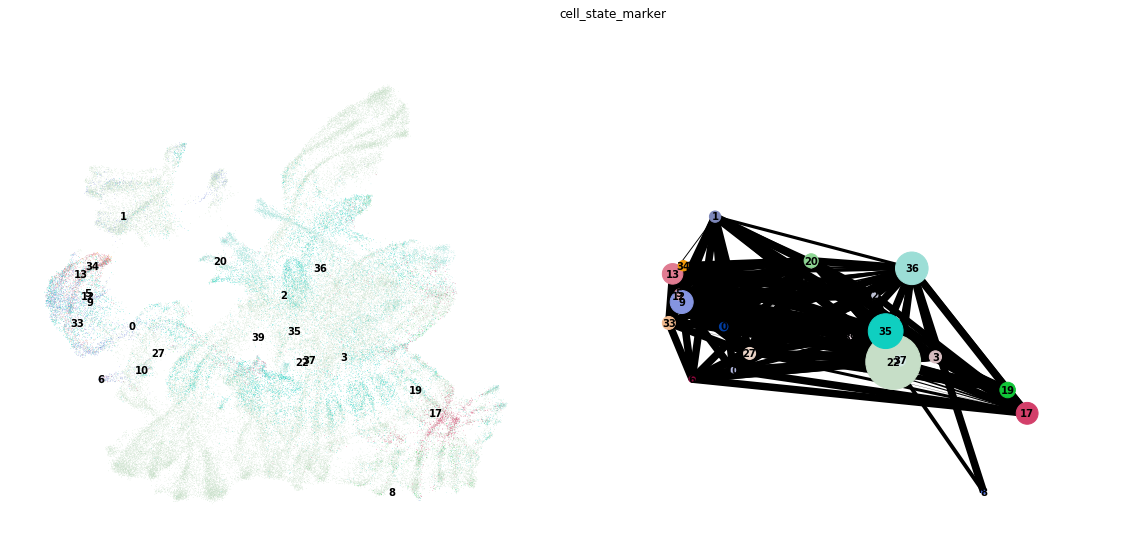

In [54]:
sc.pl.paga_compare(adata, basis='umap')

--> added 'pos', the PAGA positions (adata.uns['paga'])


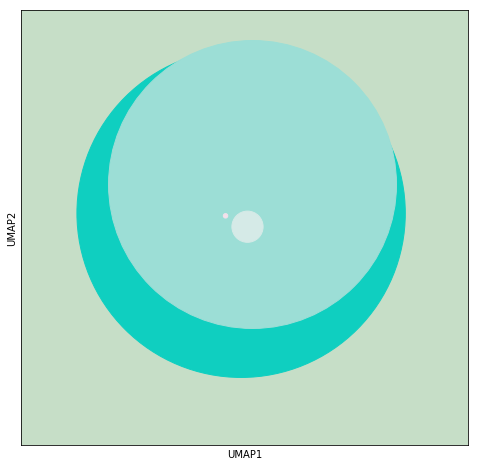

In [55]:
fig1, ax1 = plt.subplots()
sc.pl.umap(adata, size=40, ax=ax1, show=False)
sc.pl.paga(adata, pos=adata.uns['paga']['pos'], show=False, node_size_scale=10, node_size_power=1, ax=ax1, text_kwds={'alpha':0})
#plt.savefig('./figures/umap_paga_overlay_gut.pdf', dpi=300, format='pdf')
plt.show()

In [46]:
adata

AnnData object with n_obs × n_vars = 92649 × 712 
    obs: 'exp_number', 'sample', 'stage', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'groups', 'cell_state_marker'
    var: 'gene_id'
    uns: 'pca', 'neighbors', 'louvain', 'diffmap_evals', 'draw_graph', 'cell_state_marker_colors', 'paga', 'cell_state_marker_sizes'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_diffmap', 'X_draw_graph_fa'
    varm: 'PCs'
    layers: 'counts'

In [45]:
results_file = './write/clusters.h5ad'
adata.write(results_file, compression='gzip')